In [1]:
import tensorflow as tf
from keras.layers import Lambda
import numpy as np
from matplotlib import pyplot as plt

In [2]:
N_DIM = 100
N_SAMPLES = 15000

In [3]:
def slice_func(x, start, size):
    return tf.slice(x, [0,start],[-1,size])

def perm_func(x, ind):
    return tf.gather(x, indices=ind, axis=-1)

def realnvp_layer(x_input):
    DD = x_input.shape[-1]; ## DD needs to be an even number
    dd = (DD//2);
    
    ## define some lambda functions
    clamp_func = Lambda(lambda x: 0.1*tf.tanh(x));
    trans_func = Lambda(lambda x: x[0]*tf.exp(x[1]) + x[2]);
    sum_func = Lambda(lambda x: tf.reduce_sum(-x, axis=-1, keepdims=True));
    
    ## compute output for s and t functions
    x_input1 = Lambda(slice_func, arguments={'start':0,'size':dd})(x_input);
    x_input2 = Lambda(slice_func, arguments={'start':dd,'size':dd})(x_input);
    st_output = x_input1;
    
    n_nodes = [dd//2, dd//2, DD];
    act_func = ['relu', 'relu', 'linear'];
    for ii in range(len(act_func)):
        st_output = tf.keras.layers.Dense(n_nodes[ii], activation = act_func[ii])(st_output);
    s_output = Lambda(slice_func, arguments={'start':0,'size':dd})(st_output);
    t_output = Lambda(slice_func, arguments={'start':dd,'size':dd})(st_output);
    s_output = clamp_func(s_output); ## keep small values of s
    
    ## perform transformation
    trans_x = trans_func([x_input2, s_output, t_output]);
    output = tf.keras.layers.concatenate([trans_x, x_input1], axis=-1);
    return output

def realnvp_block(x_output):
    for _ in range(2):
        x_output = realnvp_layer(x_output);
    return x_output

def simulate_cont_data_diff_var(length, n_dim):
    ## simulate 2d z
    np.random.seed(777);
    
    u_true = np.random.uniform(0,2*np.pi,size = [length,1]);
    mu_true = np.hstack((u_true, 2*np.sin(u_true)));
    var_true = 0.15*np.abs(mu_true);
    var_true[:,0] = 0.6-var_true[:,1];
    z_true = np.random.normal(0, 1, size=[length,2])*np.sqrt(var_true)+mu_true;
    z_true = np.hstack((z_true, np.zeros((z_true.shape[0],n_dim-2))));
    
    ## simulate mean
    dim_x = z_true.shape[-1];
    permute_ind = [];
    n_blk = 4;
    for ii in range(n_blk):
        np.random.seed(ii);
        permute_ind.append(tf.convert_to_tensor(np.random.permutation(dim_x)));
    
    x_input = tf.keras.layers.Input(shape=(dim_x,));
    x_output = realnvp_block(x_input);
    for ii in range(n_blk-1):
        x_output = Lambda(perm_func, arguments={'ind':permute_ind[ii]})(x_output);
        x_output = realnvp_block(x_output);
    
    realnvp_model = tf.keras.Model(inputs=[x_input], outputs=x_output);
    mean_true = realnvp_model.predict(z_true)
    lam_true = np.exp(2.2*np.tanh(mean_true));
    return z_true, u_true, mean_true, lam_true

z_true, u_true, _, lam_true = simulate_cont_data_diff_var(N_SAMPLES,N_DIM)
x_true = tf.random.poisson(shape=(), lam=lam_true)


469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [129]:
class FirstLayerGIN(tf.keras.layers.Layer):
    def __init__(self, observed_dim, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.observed_dim = observed_dim
        self.n_nodes = [max(32, observed_dim // 4), max(32, observed_dim // 4), observed_dim - latent_dim]   # observed_dim - z_dim (2)
        self.activations = ["relu", "relu", "linear"]

        # define Dense layers once
        self.denses = [
            tf.keras.layers.Dense(self.n_nodes[i], activation=self.activations[i])
            for i in range(len(self.n_nodes))
        ]

    def call(self, z):
        j = z
        for dense in self.denses:
            j = dense(j)
        output = tf.keras.layers.concatenate([z, j], axis=-1)
        return output
    
class GINBlock(tf.keras.layers.Layer):
    def __init__(self, n_blocks, observed_dim, **kwargs):
        super().__init__(**kwargs)
        self.n_blocks = n_blocks
        self.n_nodes = [32, 32, 32]   # last size depends on input
        self.activations = ["relu", "relu", "relu"]
        self.observed_dim = observed_dim
        # Dense blocks except the last one (we’ll set last in __init__ when we know input size)
        self.denses = [
            tf.keras.layers.Dense(self.n_nodes[i], activation=self.activations[i])
            for i in range(n_blocks-1)
        ]

        # placeholder, will be set dynamically in build()
        self.final_dense = None

        self.sum_func = tf.keras.layers.Lambda(lambda x:  tf.reduce_sum(x, axis=-1, keepdims=True))
        self.trans_func = tf.keras.layers.Lambda(lambda x: x[0] * tf.exp(x[1]) + x[2])
 
    def build(self, input_shape): # builds the last layer 
        N = int(input_shape[-1])
        n = N // 2
        final_units = 2 * (N - n) - 1
        self.final_dense = tf.keras.layers.Dense(final_units, activation="linear")
        super().build(input_shape)

    def slice_func(self, x, start, size):
        if size is None:
            return x[..., start:]
        return x[..., start:start + size]

    def perm_func(self,x, ind):
        return tf.gather(x, indices=ind, axis=-1)
    
    def call(self, x):
        N = x.shape[-1]
        n = N // 2

        x_input1 = self.slice_func(x, 0, n)
        x_input2 = self.slice_func(x, n, N - n)

        st = x_input1

        for dense in self.denses:
            st = dense(st)
        st = self.final_dense(st)

        s_output = self.slice_func(st, 0, N - n - 1)
        t_output = self.slice_func(st, N - n - 1, N - n)

        s_output = 0.1 * tf.tanh(s_output)  # clamp
        s_output = tf.keras.layers.concatenate([s_output, -self.sum_func(s_output)], axis=-1)

        transformed = self.trans_func([x_input2, s_output, t_output])
        return tf.keras.layers.concatenate([transformed, x_input1], axis=-1)

class Encoder(tf.keras.Model):
    def __init__(self, observed_dim, latent_dim):
        super(Encoder, self).__init__()
        self.observed_dim = observed_dim
        self.latent_dim = latent_dim

        # define layers once
        self.d1 = tf.keras.layers.Dense(60, activation='tanh')
        self.d2 = tf.keras.layers.Dense(60, activation='tanh')
        # self.d3 = tf.keras.layers.Dense(60, activation='tanh')
        # self.d4 = tf.keras.layers.Dense(64, activation='tanh')


        # mean / log-variance heads: linear outputs (no ReLU)
        self.z_mean_layer = tf.keras.layers.Dense(self.latent_dim, activation=None)
        self.z_log_var_layer = tf.keras.layers.Dense(self.latent_dim, activation=None)

    def call(self, x):
        # x = tf.cast(x, tf.float32)
        x = self.d1(x)
        x = self.d2(x)
        # x = self.d3(x)
        # x = self.d4(x)
        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        return z_mean, z_log_var

class Prior(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Prior, self).__init__()
        self.latent_dim = latent_dim

        self.d1 = tf.keras.layers.Dense(20, activation='tanh')
        self.d2 = tf.keras.layers.Dense(20, activation='tanh')
        # self.d3 = tf.keras.layers.Dense(20, activation='linear')
        self.lam_mean_layer = tf.keras.layers.Dense(self.latent_dim, activation=None)
        self.lam_log_var_layer = tf.keras.layers.Dense(self.latent_dim, activation=None)

    def call(self, u):
        # u = tf.cast(u, tf.float32)
        u = self.d1(u)
        u = self.d2(u)
        # u = self.d3(u)
        lam_mean = self.lam_mean_layer(u)
        lam_log_var = self.lam_log_var_layer(u)
        return lam_mean, lam_log_var

class Permutation(tf.keras.Model):
    def __init__(self, in_channels: int, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        # Create permutation and inverse permutation
        p = tf.random.shuffle(tf.range(in_channels))
        invp = tf.argsort(p)
        self.p = tf.Variable(p, trainable=False, dtype=tf.int32)
        self.invp = tf.Variable(invp, trainable=False, dtype=tf.int32)

    def call(self, x, reverse=False):
        # x shape: [batch_size, in_channels]
        assert x.shape[-1] == self.in_channels, f"Expected last dim {self.in_channels}, got {x.shape[-1]}"
        if reverse:
            return tf.gather(x, self.invp, axis=-1)
        else:
            return tf.gather(x, self.p, axis=-1)
        
class Decoder(tf.keras.Model):
    def __init__(self, observed_dim, latent_dim):
        super(Decoder, self).__init__()
        self.observed_dim = observed_dim
        self.latent_dim = latent_dim
        # self.d1 = tf.keras.layers.Dense(20, activation='tanh')
        # self.d2 = tf.keras.layers.Dense(20, activation='tanh')
        self.first_layer_gin = FirstLayerGIN(observed_dim=observed_dim, latent_dim=latent_dim)
        self.gin_block = GINBlock(3, observed_dim=observed_dim)

        self.out = tf.keras.layers.Dense(self.observed_dim, activation="softplus")

        self.gin_blocks = []
        for _ in range(2):  # Number of blocks
            # Add permutation
            self.gin_blocks.append(Permutation(observed_dim))
            # Add GIN block
            self.gin_blocks.append(GINBlock(observed_dim=observed_dim, n_blocks=3))

    def call(self, z):
        # z = tf.cast(z, tf.float32)
        # z = self.d1(z)
        # z = self.d2(z)
        z = self.first_layer_gin(z)
        # for _ in range(2):
            # z = self.gin_block(z)
        for g in self.gin_blocks:
            z = g(z)
        output = self.out(z)
        return output

class PIVAE(tf.keras.Model):
    def __init__(self, observed_dim, latent_dim, kl_weight=1.0):
        super(PIVAE, self).__init__()
        self.observed_dim = observed_dim
        self.latent_dim = latent_dim
        self.encoder = Encoder(observed_dim=observed_dim, latent_dim=latent_dim)
        self.decoder = Decoder(observed_dim=observed_dim, latent_dim=latent_dim)
        self.prior = Prior(latent_dim=latent_dim)
        self.kl_weight = kl_weight

    @staticmethod 
    def compute_posterior_params(z_mean, z_log_var, lam_mean, lam_log_var):
        # numerically stable combination of two Gaussians (posterior merging)
        diff_log_var = z_log_var - lam_log_var
        post_mean = (z_mean / (1.0 + tf.exp(diff_log_var))) + (lam_mean / (1.0 + tf.exp(-diff_log_var)))
        post_log_var = z_log_var + lam_log_var - tf.math.log(tf.exp(z_log_var) + tf.exp(lam_log_var))
        return post_mean, post_log_var


    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * eps
    
    def call(self, x, u):
        # u_input = tf.expand_dims(u, axis=-1)
        lam_mean, lam_log_var = self.prior(u)
        z_mean, z_log_var = self.encoder(x)
        post_mean, post_log_var = self.compute_posterior_params(z_mean, z_log_var, lam_mean, lam_log_var)
        s = self.reparameterize(post_mean, post_log_var)
        x_pred = self.decoder(s)
        # return prediction and posterior params for loss computation
        return x_pred, post_mean, post_log_var, lam_mean, lam_log_var

    def compute_kl_loss(self, post_mean, post_log_var, lam_mean, lam_log_var):
        # kl_per_dim = 1 + post_log_var - lam_log_var - ((tf.square(post_mean - lam_mean) + tf.exp(post_log_var)) / tf.exp(lam_log_var))
        # kl = -0.5 * tf.reduce_sum(kl_per_dim, axis=-1)  # sum over dims, shape (batch,)
        diff_means2 = (post_mean-lam_mean)**2
        post_var, lam_var = tf.exp(post_log_var), tf.exp(lam_log_var)
        kl_loss = 1 + post_log_var - lam_log_var - ((diff_means2 + post_var) / lam_var)
        kl_loss = -0.5 * tf.reduce_sum(kl_loss, -1)
        return kl_loss     

    def train_step(self, data):
        x_input, y_target = data
        
        x_input = tf.cast(x_input, tf.float32)
        y_target = tf.cast(y_target, tf.float32)

        with tf.GradientTape() as tape:
            x_pred, post_mean, post_log_var, lam_mean, lam_log_var = self(x_input, y_target, training=True)

            # Poisson negative log-likelihood per sample (drop log x! since it’s constant):
            #   nll = sum( λ - x*log(λ) )
            recon_per_sample = tf.reduce_sum(x_pred - x_input * tf.math.log(tf.clip_by_value(x_pred,1e-7, 1e7)), axis=-1)
            kl_loss = self.compute_kl_loss(post_mean, post_log_var, lam_mean, lam_log_var)

            total_loss = tf.reduce_mean(recon_per_sample + self.kl_weight * kl_loss)  # <- scalar

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {
            "loss": total_loss,
            "recon_loss": tf.reduce_mean(recon_per_sample),
            "kl_loss": tf.reduce_mean(kl_loss)
        }
    

    def test_step(self, data):
        x_input, y_target = data
        x_input = tf.cast(x_input, tf.float32)
        y_target = tf.cast(y_target, tf.float32)

        x_pred, post_mean, post_log_var, lam_mean, lam_log_var = self(x_input, y_target, training=False)
        recon_per_sample = tf.reduce_sum(x_pred - x_input * tf.math.log(tf.clip_by_value(x_pred, 1e-7, 1e7)), axis=-1)
        kl_loss = self.compute_kl_loss(post_mean, post_log_var, lam_mean, lam_log_var)
        total_loss = tf.reduce_mean(recon_per_sample + self.kl_weight * kl_loss)

        return {
            "loss": total_loss,
            "recon_loss": tf.reduce_mean(recon_per_sample),
            "kl_loss": tf.reduce_mean(kl_loss)
        }

In [130]:
x_train = x_true[:10000]
x_val  = x_true[10000:15000]

u_train = u_true[:10000]
u_val = u_true[10000:15000]

In [ ]:
pivae = PIVAE(N_DIM, 2)
pivae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
fit = pivae.fit(x_train, u_train, epochs=70, batch_size=50, verbose=2, validation_data=(x_val, u_val))

Epoch 1/70


c:\Users\kangj\OneDrive\Desktop\pivae\myenv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'decoder_53', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


200/200 - 12s - 60ms/step - kl_loss: 0.8966 - loss: 114.9553 - recon_loss: 114.0587 - val_kl_loss: 1.0426 - val_loss: 113.7571 - val_recon_loss: 112.7145
Epoch 2/70
200/200 - 2s - 9ms/step - kl_loss: 1.1689 - loss: 110.4037 - recon_loss: 109.2348 - val_kl_loss: 1.0295 - val_loss: 109.3142 - val_recon_loss: 108.2847
Epoch 3/70
200/200 - 2s - 8ms/step - kl_loss: 1.2457 - loss: 102.7182 - recon_loss: 101.4725 - val_kl_loss: 1.4441 - val_loss: 103.7674 - val_recon_loss: 102.3232
Epoch 4/70
200/200 - 2s - 8ms/step - kl_loss: 2.2012 - loss: 92.5749 - recon_loss: 90.3738 - val_kl_loss: 2.0472 - val_loss: 94.6604 - val_recon_loss: 92.6132
Epoch 5/70
200/200 - 2s - 8ms/step - kl_loss: 2.4799 - loss: 86.8250 - recon_loss: 84.3451 - val_kl_loss: 2.4100 - val_loss: 86.9006 - val_recon_loss: 84.4907
Epoch 6/70
200/200 - 2s - 8ms/step - kl_loss: 2.5519 - loss: 79.4371 - recon_loss: 76.8852 - val_kl_loss: 2.4335 - val_loss: 81.8824 - val_recon_loss: 79.4489
Epoch 7/70
200/200 - 2s - 9ms/step - kl_los

In [ ]:
lam_mean, lam_log_var = pivae.prior(u_val)
z_mean, z_log_var = pivae.encoder(x_val)
post_mean, post_log_var = pivae.compute_posterior_params(z_mean, z_log_var, lam_mean, lam_log_var)
s = pivae.reparameterize(post_mean, post_log_var)

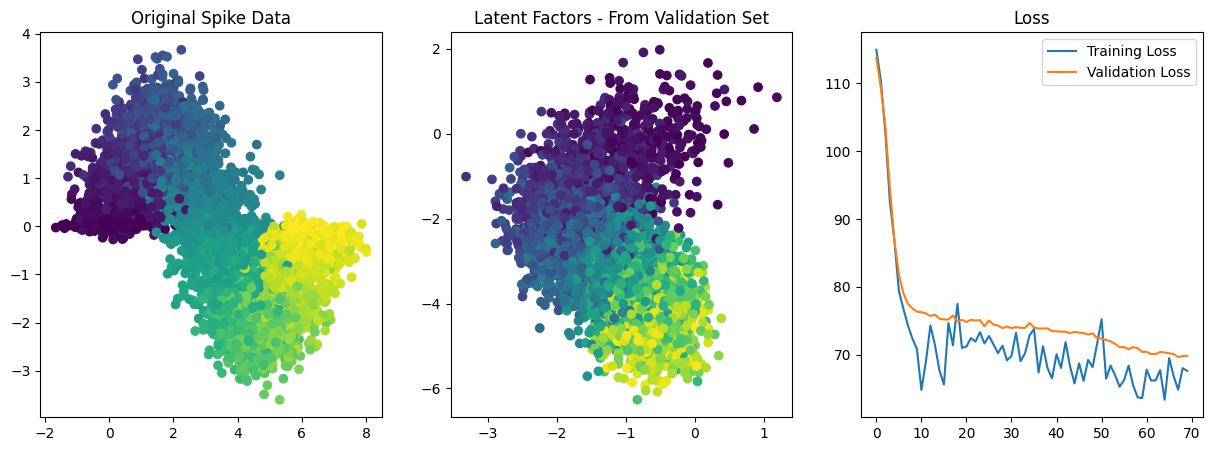

In [144]:
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(x=z_true[10000:15000, 0], y=z_true[10000:15000, 1], c=u_val)
ax[0].set_title("Original Spike Data")
ax[1].scatter(s[:, 0], s[:, 1], c=u_val, cmap='viridis')
ax[1].set_title("Latent Factors - From Validation Set")
ax[2].plot(fit.history['loss'][:], label="Training Loss")
ax[2].plot(fit.history['val_loss'][:], label="Validation Loss")
ax[2].set_title("Loss")
ax[2].legend()
plt.show()